# ДЗ к Урок 1. Вводный (Понятие об оптимизации)

## Практическое задание

В проектируемой локальной сети есть заданное количество компьютеров. <br>
Есть расстояния от каждого компьютера до сервера и до остальных компьютеров. <br>
Маршрутизаторы соединяются с сервером через оптоволокно стоимостью 12 р/м, а компьютеры с маршрутизаторами соединяются через витую пару стоимостью 30 р/м.

Каждый маршрутизатор имеет 8 портов для витой пары и один оптический порт.<br>
Сервер имеет неограниченное число оптических портов и портов для витой пары. Компьютер может соединяться с сервером напрямую или через маршрутизатор.<br>
1. Построить ЦФ для расчёта стоимости оборудования ЛВС в общем виде. Учесть стоимость маршрутизатора, обоснованность его установки.
2. Построить поверхность стоимости от сумм расстояний для конкретного примера. Количество компьютеров — больше двух, располагаются не на одной линии в одной четверти относительно сервера.*

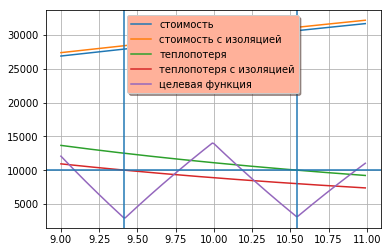

In [ ]:
import numpy as np              
import matplotlib.pyplot as plt 
import math

P = np.arange(9, 11, 0.01)                           # ряд от -1,0 до 1,1 с шагом 0,1
S = P*200/(2*180+P)                                  # выражение для толщины стенки
T100 = 90 - 120/(0.2*P*S)                            # выражение для температуры в контрольной точке для магистрали без изоляции
dT = (90 - T100)*1000                                # выражения для теплопотери для магистрали без изоляции, масштаб 1000

costp = 0.005*100*50*(400 - (20 - S)*(20 - S))*6.28  # стоимость зависит от площади сечения, умножена на к-т масштаба 0,005
dT2 = dT*0.8                                         # намотка одного слоя изоляции снижает теплоотдачу на 20%, масштаб 1000
costi = 1000*100*0.005                               # cтоимость намотки одного слоя изоляции умножена на к-т масштаба 0,005
costf = costp + costi

TF1 = (np.abs(10000 - dT) + costp / 100) * 10     
TF2 = (np.abs(10000 - dT2) + costf / 100) * 10   
TF = np.minimum(TF1, TF2)                            # целевая функция
# рассматриваются точки с максимально допустимой теплопотерей;
# в этих точках оценивается стоимость решений
# постоянные и множители взяты с учётом масштабов

fig, ax = plt.subplots()                                                                         # прорисовка осей

ax.plot(P, costp)                                                                                # прорисовка графика стоимости материалов
ax.plot(P, costf)                                                                                # прорисовка графика стоимости материалов c изоляцией
ax.plot(P, dT)                                                                                   # прорисовка графика теплопотерь
ax.plot(P, dT2)                                                                                  # прорисовка графика теплопотерь с изоляцией
ax.plot(P, TF)                                                                                   # прорисовка графика целевой функции

plt.axhline(y=10000)                                                                             # допустимая теплопотеря 10 градусов Цельсия
plt.axvline(x=10.545)                                                                            # второе оптимальное давление
plt.axvline(x=9.415)                                                                             # первое оптимальное давление
ax.grid()                                                                                        # прорисовка сетки
 
lgnd = ax.legend(['стоимость', 'стоимость с изоляцией', 'теплопотеря',\
                  'теплопотеря с изоляцией','целевая функция'], loc='upper center', shadow=True) # легенда
lgnd.get_frame().set_facecolor('#ffb19a')                                                        # рамка легенды
 
plt.show()                                                                                       # вывод графика